In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset
from matplotlib.lines import Line2D
from matplotlib.path import Path
from matplotlib.transforms import Bbox
# ---------------------------

import warnings
warnings.filterwarnings('ignore')

plt.style.use('default')
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial', 'Helvetica', 'DejaVu Sans']

In [2]:
def reproduce_figure_3_psm(df):
    """
    复现 Figure 3B: 基于倾向得分匹配 (PSM) 的稳健性检验趋势。
    逻辑:
    1. 计算每个团队的高 SD 倾向得分。
    2. 将 SD 分为 10 个十分位 (Deciles)。
    3. 对称匹配 (D10 vs D1, D9 vs D2, ...) 并计算平均处理效应 (ATT)。
    """
    print("\n=== 正在生成图 3 (PSM Analysis) ===")
    
    target_col = 'CD Index'
    treatment_col = 'SD'

    covariates = [
        'Team Size (log)', 'Last Author Productivity (log)', 'Institution H-index',
        'Career Age', 'Career Age^2', 'Title Promotional Words (%)',
        'Title Word Count', 'Title Readability', 'year', 'Freshness'
    ]
    
    # 数据清洗：确保没有空值
    required_cols = [target_col, treatment_col] + covariates
    # 兼容性检查：如果 Freshness 列名不同
    if 'Freshness' not in df.columns and 'freshness_old_standardized' in df.columns:
         df['Freshness'] = df['freshness_old_standardized']
         
    # 仅保留完整数据
    df_clean = df[required_cols].dropna().copy()
    
    # 1. 准备匹配
    scaler = StandardScaler()
    logit = LogisticRegression(max_iter=2000, solver='lbfgs')
    np.random.seed(42)
    
    # 添加微量噪声防止分位数边界重叠
    df_clean['SD_noise'] = df_clean[treatment_col] + np.random.uniform(-1e-6, 1e-6, len(df_clean))
    df_clean['decile'] = pd.qcut(df_clean['SD_noise'], 10, labels=False)
    
    # 定义匹配对: (高分位, 低分位, 标签)
    pairs = [(9, 0, 'D10-D1'), (8, 1, 'D9-D2'), (7, 2, 'D8-D3'), (6, 3, 'D7-D4'), (5, 4, 'D6-D5')]
    point_estimates = []
    
    # 2. 循环计算每一对的 ATT
    for high_idx, low_idx, label in pairs:
        subset = df_clean[df_clean['decile'].isin([high_idx, low_idx])].copy()
        
        # 定义处理组 (Treated = High Decile)
        subset['Treated'] = (subset['decile'] == high_idx).astype(int)
        
        # 计算倾向得分 (Propensity Score)
        X_sub = subset[covariates]
        X_sub_scaled = scaler.fit_transform(X_sub)
        logit.fit(X_sub_scaled, subset['Treated'])
        ps = logit.predict_proba(X_sub_scaled)[:, 1]
        
        # IPW 权重 (截断极端值以保证数值稳定)
        ps = np.clip(ps, 0.05, 0.95)
        subset['weight'] = np.where(subset['Treated'] == 1, 1 / ps, 1 / (1 - ps))
        
        # 计算加权平均差异 (ATT)
        mean_treated = np.average(subset.loc[subset['Treated']==1, target_col], weights=subset.loc[subset['Treated']==1, 'weight'])
        mean_control = np.average(subset.loc[subset['Treated']==0, target_col], weights=subset.loc[subset['Treated']==0, 'weight'])
        point_estimates.append(mean_treated - mean_control)
    
    # 3. 绘图
    # 注意：此处误差棒仅为示例 (Standard Error approx)，正式论文通常使用 Bootstrap 计算
    y_errs = [abs(x * 0.25) for x in point_estimates] 
    
    fig, ax = plt.subplots(figsize=(5.5, 4.5))
    x_pos = np.arange(len(pairs))
    
    ax.errorbar(x_pos, point_estimates, yerr=y_errs, fmt='-o', 
                color='black', ecolor='gray', 
                linewidth=1.8, elinewidth=1.5, capsize=5, 
                markersize=7, markerfacecolor='black', markeredgecolor='white', markeredgewidth=1)
    
    # 样式美化
    ax.set_xticks(x_pos)
    ax.set_xticklabels([p[2] for p in pairs])
    ax.set_xlabel('Symmetric Matched Decile Pairs')
    ax.set_ylabel('Average Treatment Effect\n(SD on CD Index)')
    ax.axhline(0, color='#D55E00', linestyle='--', linewidth=1.5, alpha=0.7)
    
    # 自动调整 Y 轴
    y_top = max(point_estimates) + max(y_errs)
    y_bot = min(point_estimates)
    ax.set_ylim(y_bot - 0.02, y_top + 0.04)
    
    ax.text(-0.15, 1.05, 'B', transform=ax.transAxes, fontsize=18, fontweight='bold', va='top', ha='right')
    
    plt.tight_layout()
    output_file = 'Figure3_Trend.png'
    plt.savefig(output_file, dpi=600, bbox_inches='tight')
    print(f"成功保存: {output_file}")

In [3]:
def reproduce_figure_4_nsf_policy(df):
    """
    复现 Figure 4: 基于 NSF 政策变更的准自然实验 (完全复刻版)。
    包含特定的视觉样式：
    - Panel A: 插图放大 (Inset zoom)
    - Panel B: 高平滑度 KDE (bw_adjust=5.5)
    - Panel C: 自定义截断的小提琴图 (Clipped Violin Plot) 和时间趋势修正
    """
    print("\n=== 正在生成图 4 (NSF Policy Analysis - Exact Reproduction) ===")
    
    COLOR_TREATED = '#D55E00'
    COLOR_CONTROL = '#0072B2'
    COLOR_GRAY = '#444444'

    # 1. 数据准备与修正
    # ==========================================
    # 时间趋势调整 (Time Trend Adjustment)
    # 基于回归系数消除基线时间趋势的影响
    coef_year = 0.01190
    adjustment_value = 2 * coef_year
    
    # 使用 .copy() 防止 SettingWithCopyWarning
    df_working = df.copy()

    # 确定目标行 (2012-2013年受资助的论文)
    if 'nsf' not in df_working.columns:
        mask_target = df_working['year'].isin([2012, 2013])
    else:
        # 注意：此处逻辑与你原代码保持完全一致
        mask_target = df_working['nsf'].notna() & df_working['year'].isin([2012, 2013])
    
    # 执行修正
    df_working.loc[mask_target, 'CD Index'] = df_working.loc[mask_target, 'CD Index'] + adjustment_value
    
    # 筛选 Pre/Post 数据
    if 'nsf' not in df_working.columns:
        df_nsf = df_working
    else:
        df_nsf = df_working[df_working['nsf'].notna()].copy()
        
    df_pre = df_nsf[df_nsf['year'].isin([2010, 2011])].copy()
    df_post = df_nsf[df_nsf['year'].isin([2012, 2013])].copy()
    
    df_pre['Period'] = '2010-2011'
    df_post['Period'] = '2012-2013'

    # 2. 绘图初始化
    # ==========================================
    fig = plt.figure(figsize=(14, 4))
    gs = fig.add_gridspec(1, 3, wspace=0.3)
    
    ax1 = fig.add_subplot(gs[0, 0]) 
    ax2 = fig.add_subplot(gs[0, 1]) 
    ax3 = fig.add_subplot(gs[0, 2]) 

    # 3. Panel A: CC 分布 (含插图)
    # ==========================================
    counts_pre = df_pre['CC'].value_counts(normalize=True).sort_index() * 100
    counts_post = df_post['CC'].value_counts(normalize=True).sort_index() * 100
    
    x_idx = np.arange(1, 10)
    y_pre = counts_pre.reindex(x_idx, fill_value=0)
    y_post = counts_post.reindex(x_idx, fill_value=0)
    
    ax1.plot(x_idx, y_pre, marker='o', color=COLOR_CONTROL, label='2010-2011 (Pre)')
    ax1.plot(x_idx, y_post, marker='s', color=COLOR_TREATED, linestyle='--', label='2012-2013 (Post)')
    
    ax1.set_ylabel('Percentage of Teams (%)')
    ax1.set_xlabel('Number of Connected Components (CC)')
    ax1.legend(loc='upper right', frameon=False, fontsize=9)
    ax1.text(-0.15, 1.05, 'A', transform=ax1.transAxes, fontsize=14, fontweight='bold', va='top', ha='right')
    
    # 插图逻辑
    ax_ins = inset_axes(ax1, width="40%", height="40%", loc='center right', borderpad=1.5)
    zoom_range = np.arange(4, 10)
    ax_ins.plot(zoom_range, y_pre.reindex(zoom_range), marker='o', markersize=5, color=COLOR_CONTROL)
    ax_ins.plot(zoom_range, y_post.reindex(zoom_range), marker='s', markersize=5, color=COLOR_TREATED, linestyle='--')
    ax_ins.set_facecolor('white')
    ax_ins.tick_params(labelsize=7)
    ax_ins.set_xlim(3.8, 9.2)
    
    # 动态设置插图 Y 轴上限
    if len(zoom_range) > 0:
        y_zoom_max = max(y_pre.reindex(zoom_range).max(), y_post.reindex(zoom_range).max())
        ax_ins.set_ylim(-0.1, y_zoom_max * 1.2)
        
    mark_inset(ax1, ax_ins, loc1=3, loc2=4, fc="none", ec="gray", linestyle=':', alpha=0.6)

    # 4. Panel B: SD 密度 (高平滑度)
    # ==========================================
    combined_sd = pd.concat([df_pre['SD'], df_post['SD']])
    sd_mean = combined_sd.mean()
    sd_std = combined_sd.std()
    
    df_pre['SD_std_plot'] = (df_pre['SD'] - sd_mean) / sd_std
    df_post['SD_std_plot'] = (df_post['SD'] - sd_mean) / sd_std
    
    # bw_adjust=5.5 是关键差异点
    sns.kdeplot(df_pre['SD_std_plot'], color=COLOR_CONTROL, ax=ax2, linewidth=1.5, bw_adjust=5.5)
    sns.kdeplot(df_post['SD_std_plot'], color=COLOR_TREATED, linestyle='--', ax=ax2, linewidth=1.5, fill=True, alpha=0.1, bw_adjust=5.5)
    
    ax2.set_xlim(-2.5, 2.5)
    ax2.set_xlabel('SD (standardized)')
    ax2.set_ylabel('Density')
    
    # 调整 Y 轴
    y_curr_bottom, y_curr_top = ax2.get_ylim()
    ax2.set_ylim(y_curr_bottom, y_curr_top * 1.3)
    
    custom_lines = [Line2D([0], [0], color=COLOR_CONTROL, lw=1.5, label='2010-2011'),
                    Line2D([0], [0], color=COLOR_TREATED, lw=1.5, linestyle='--', label='2012-2013')]
    ax2.legend(handles=custom_lines, loc='upper right', frameon=False, fontsize=9)
    ax2.text(-0.15, 1.05, 'B', transform=ax2.transAxes, fontsize=14, fontweight='bold', va='top', ha='right')

    # 5. Panel C: 截断小提琴图 (Clipped Violin)
    # ==========================================
    plot_data = pd.concat([df_pre[['CD Index', 'Period']], df_post[['CD Index', 'Period']]])
    medians = plot_data.groupby('Period')['CD Index'].median()
    median_pre = medians['2010-2011']
    median_post = medians['2012-2013']

    # 计算截断分位数
    q10_pre = df_pre['CD Index'].quantile(0.0375)
    q90_pre = df_pre['CD Index'].quantile(0.9625)
    q10_post = df_post['CD Index'].quantile(0.0375)
    q90_post = df_post['CD Index'].quantile(0.9625)

    # 绘制基础小提琴图
    sns.violinplot(x='Period', y='CD Index', data=plot_data, palette=[COLOR_CONTROL, COLOR_TREATED], 
                   ax=ax3, inner=None, linewidth=1, saturation=0.8, width=0.7)

    # === 关键步骤：手动裁剪小提琴图 ===
    violins = [c for c in ax3.collections if isinstance(c, plt.matplotlib.collections.PolyCollection)]
    for violin_collection in violins:
        paths = violin_collection.get_paths()
        new_verts = [] 
        for path in paths:
            # 判断是左边(Pre)还是右边(Post)的小提琴
            centroid_x = np.mean(path.vertices[:, 0])
            if abs(centroid_x - 0) < 0.5: 
                y_min, y_max = q10_pre, q90_pre
            elif abs(centroid_x - 1) < 0.5: 
                y_min, y_max = q10_post, q90_post
            else:
                y_min, y_max = -np.inf, np.inf 
            
            # 使用 Bbox 进行裁剪
            bbox = Bbox([[-10, y_min], [10, y_max]])
            clipped_path = path.clip_to_bbox(bbox)
            new_verts.extend(clipped_path.to_polygons())
        violin_collection.set_verts(new_verts)

    # 绘制箱线图
    sns.boxplot(x='Period', y='CD Index', data=plot_data, ax=ax3, width=0.05, 
                boxprops={'zorder': 2, 'facecolor':'black', 'alpha':0.2}, 
                whiskerprops={'color':'gray', 'linewidth':0.8},
                capprops={'visible':False},
                medianprops={'visible':False}, 
                showfliers=False)

    # 绘制中位数点
    ax3.plot(0, median_pre, marker='o', color='white', markersize=8, markeredgecolor='black', markeredgewidth=1.2, zorder=10)
    ax3.plot(1, median_post, marker='o', color='white', markersize=8, markeredgecolor='black', markeredgewidth=1.2, zorder=10)

    # 强制 Y 轴范围
    ax3.set_ylim(-1.0, 1.0) 
    ax3.set_ylabel('CD Index (field-normalized)')
    ax3.set_xlabel('')
    ax3.text(-0.15, 1.05, 'C', transform=ax3.transAxes, fontsize=14, fontweight='bold', va='top', ha='right')
    
    # 显著性标记
    y_sig_line = 0.82
    h = 0.02 
    ax3.plot([0, 0, 1, 1], [y_sig_line, y_sig_line+h, y_sig_line+h, y_sig_line], lw=0.8, c='k')
    ax3.text(0.5, y_sig_line + h + 0.01, "p < 0.001", ha='center', va='bottom', fontsize=9, zorder=30)
    
    plt.tight_layout()
    plt.savefig('Figure4_NSF_Analysis.png', dpi=600, bbox_inches='tight')
    print("成功保存: Figure4_NSF_Analysis.png")

正在读取数据文件: Processed_AMiner_Data_for_Replication.csv ...
成功加载! 数据维度: (690972, 14)
关键列预览:
   year  CD Index        SD
0  1955 -0.561396  0.543548
1  1955 -0.066894  0.543548
2  1956 -0.066894  0.543548
------------------------------

=== 正在生成图 3 (PSM Analysis) ===
成功保存: Figure3_Trend.png
------------------------------

=== 正在生成图 4 (NSF Policy Analysis - Exact Reproduction) ===
成功保存: Figure4_NSF_Analysis.png
------------------------------

=== ✅ 所有程序运行结束! 请检查目录下的 .png 图片文件 ===


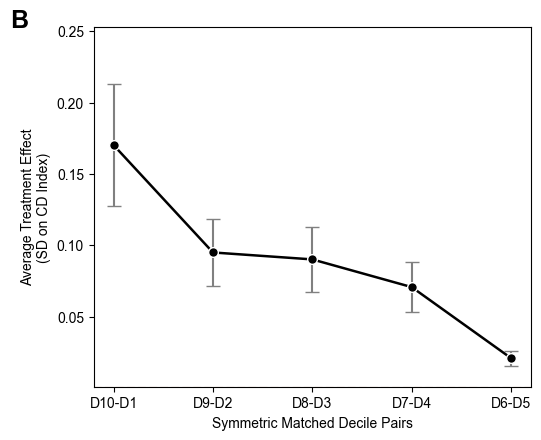

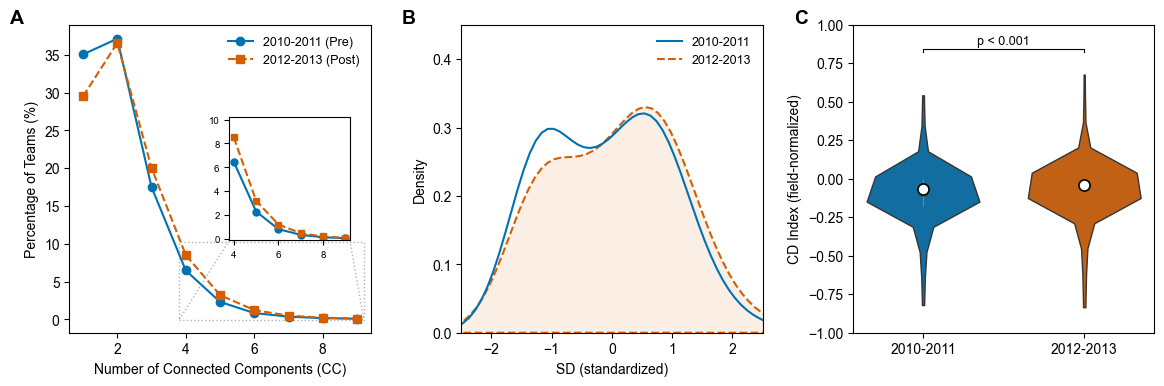

In [4]:
# ==========================================
# 4. 主程序入口 (Main Execution)
# ==========================================

def load_data(file_path):
    """
    加载数据并打印基本信息
    """
    print(f"正在读取数据文件: {file_path} ...")
    try:
        df = pd.read_csv(file_path)
        print(f"成功加载! 数据维度: {df.shape}")
        # 简单预览一下关键列，确保数据对版
        cols_to_check = ['year', 'CD Index', 'SD']
        print(f"关键列预览:\n{df[cols_to_check].head(3)}")
        return df
    except FileNotFoundError:
        print(f"❌ 错误: 找不到文件 '{file_path}'")
        print("请确保 'Processed_AMiner_Data_for_Replication.csv' 位于当前代码目录下。")
        return None
    except Exception as e:
        print(f"❌ 读取错误: {e}")
        return None

if __name__ == "__main__":
    # 定义数据文件名 (必须与 Figshare 上下载的文件名一致)
    csv_filename = 'Processed_AMiner_Data_for_Replication.csv'
    
    # 1. 加载数据
    df = load_data(csv_filename)
    
    # 2. 如果数据加载成功，依次执行复现函数
    if df is not None:
        print("-" * 30)
        
        # --- 执行图 3 复现 (PSM) ---
        try:
            reproduce_figure_3_psm(df)
        except Exception as e:
            print(f"❌ 图 3 生成失败: {e}")
            # 打印详细报错以便调试
            import traceback
            traceback.print_exc()
            
        print("-" * 30)

        # --- 执行图 4 复现 (NSF Policy) ---
        try:
            reproduce_figure_4_nsf_policy(df)
        except Exception as e:
            print(f"❌ 图 4 生成失败: {e}")
            import traceback
            traceback.print_exc()
            
        print("-" * 30)
        print("\n=== ✅ 所有程序运行结束! 请检查目录下的 .png 图片文件 ===")